# Document Classification with LDA and MLPs

In [1]:
from source_scraping import load_all, load_province
from topic_modelling import *

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC, SVC, SVR, LinearSVR

from xgboost import XGBClassifier, XGBRegressor
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Activation, ActivityRegularization
from tensorflow.keras.optimizers import SGD, Nadam, Adam, Adamax
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC

import os
import joblib

In [2]:
df = pd.read_csv('SCHEMA UPDATE - Collecting NPIs Effects - FULL.csv')
pos_df = df.dropna(subset=['oxford_government_response_category', 'source_full_text'])
categories = pd.unique([string[0] for string in pos_df['oxford_government_response_category']])

### Convert Document into Topic Vector

In [3]:
def lda_preprocess(texts, lda_model, lda_dict, stop_words=stopwords.words('english'), allowed_postags=['NOUN', 'ADJ', 'VERB']):
    partially_processed = custom_preprocess(texts, stop_words=stop_words, allowed_postags=allowed_postags)
    corpus = form_corpus(partially_processed, lda_dict)
    texts_by_topic = [lda_model.get_document_topics(doc) for doc in corpus]
    processed_texts = []
    for topic_list in texts_by_topic:
        feature_list = np.zeros(len(lda_model.get_topics()))
        for index, value in topic_list:
            feature_list[index] = value
        processed_texts.append(feature_list)
    return np.array(processed_texts)

### Geographical Words to Consider Removing

Could be improved; derivatives of words on list might not correctly be removed.

In [4]:
def geo_stop_words(df):
    flatten = lambda l: [item for sublist in l for item in sublist] # flatten code from stackoverflow...
    region_stop_words = set(flatten([reg.lower().split() for reg in df['region'].dropna()]))
    sub_region_stop_words = set(flatten([reg.lower().split() for reg in df['subregion'].dropna()]))
    geo_stop_words = region_stop_words.union(sub_region_stop_words)
    return geo_stop_words

In [5]:
def text_to_cats(df):
    text_to_cats = { }

    for index, row in df.dropna(subset=['oxford_government_response_category', 'source_full_text']).iterrows():
        ox_cat = row['oxford_government_response_category']
        if ox_cat:
            text = row['source_full_text']
            if text in text_to_cats:
                text_to_cats[text].append(ox_cat)
            else:
                text_to_cats[text] = [ox_cat]
                
    return text_to_cats

def vector_to_cats(v):
    return categories[np.nonzero(v)]

# A bit of a misnomer with one_hot... more like a_couple_hot
def process_cats(cats):
    one_hot_cat = lambda x : (categories == x[0]).astype(np.float32)
    one_hot_arr_cat = lambda a : sum([one_hot_cat(cat) for cat in a])
    vectorized = lambda y : [one_hot_arr_cat(arr) for arr in y]
    cap = lambda arr : [el if el < 1 else 1 for el in arr]
    
    return np.array([cap(el) for el in vectorized(cats)])

### Model accuracy on instances that fall into multiple categories

In [6]:
def multi_class_accuracy(y_true, y_pred):
    num_correct = 0
    num_present = 0
    for i in range(0, y_true.shape[0]):
        v = y_true[i]
        if np.count_nonzero(v) > 1:
            num_present += 1
            if (y_pred[i] == y_true[i]).all():
                num_correct += 1
                
    return num_correct / num_present

### Split DataFrame into Train and Test Sets

In [7]:
# Splits data with interventions (i.e. for multilabel classification)

def split_npi_data(df, oot=True, multilabel=True):
    df = df[df['region'] != 'Quebec']
    subsets = ['source_full_text', 'start_date']
    if multilabel:
        subsets.append('oxford_government_response_category')
    df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
    df = df.dropna(subset=subsets)
    if oot:
        df = df.sort_values(['start_date'])
    else:
        df = df.sample(frac=1)
    
    if multilabel:
        x_raw = list(text_to_cats(df).keys())
        y = list(text_to_cats(df).values())
        y = process_cats(y)
    else:
        x_raw = df['source_full_text']
        y = np.array(df['oxford_government_response_category'].notna().astype(np.float))
    
    return train_test_split(x_raw, y, shuffle=(not oot))

### Keywords

In [8]:
h_keywords = ['hospital', 'healthcare', 'vaccine', 'trial', 'clinic']
e_keywords = ['econom', 'reopen', '$', 'financ', 'financial crisis', 'economic crisis']
c_keywords = ['social distanc', 'mask', 'isolation', 'quarantine']

def overlap(arr, string):
    for word in arr:
        if word in string.lower(): return True
    return False

e = lambda arr : np.array([[overlap(e_keywords, string)] for string in arr])
h = lambda arr : np.array([[overlap(h_keywords, string)] for string in arr])
c = lambda arr : np.array([[overlap(c_keywords, string)] for string in arr])

# Target vectors look like ['H', 'C', 'E']
keywords = [h, c, e]

### Convert Texts to Input Matrix

In [9]:
def text_to_topics(raw_texts, lda_info=None, n_topics=200, stopword_ext=[], keyword_lambdas=[]):
    if lda_info is None:
        x_train_raw = raw_texts[0]
        lda_info = lda_from_list(x_train_raw, n_topic_range=range(n_topics, n_topics + 1), stopword_extensions=stopword_ext, use_coherence=False, plot=False)
    
    lda_model = lda_info['best_model']
    id2word = lda_info['id2word']
    
    topic_features = []
    keyword_features = []
    total_features = []
        
    # raw_texts is a list of lists of documents (list of list of strings)
    for text in raw_texts:
        topic_vals = lda_preprocess(text, lda_model, id2word)
        topic_features.append(topic_vals)
        
        if keyword_lambdas:
            keyword_vals = np.concatenate([kwl(text) for kwl in keyword_lambdas], axis=1).astype(np.float)
            keyword_features.append(keyword_vals)

            total_vals = np.concatenate((topic_vals, keyword_vals), axis=1)
            total_features.append(total_vals)
   
    if not keyword_lambdas:
        total_features = topic_features
    total_features.append(lda_info) # For later use
    
    return total_features

### Make Prediction on Unseen Texts

In [10]:
def predict(model, new_texts, lda_info, keywords_lambdas=[], stopword_ext=[]):
    new_texts_processed, lda_info = text_to_topics([new_texts], lda_info, stopword_ext=stopword_ext, keyword_lambdas=keywords_lambdas)
    return model.predict(new_texts_processed)

### Model Fitting

Essentially a wrapper for Keras' <code>model.fit()</code>, this function streamlines some of the setup, like TensorBoard and early stopping callbacks (pieces of code called at the end of each epoch).

In [11]:
def fit_model(model, x_train, y_train, epochs=200, validation_split=None, validation_data=None, log=True, verbose=2, name=''):
    import time

    root_logdir = os.path.join(os.curdir, "tb_logs")
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    run_logdir = os.path.join(root_logdir, run_id + name)
    
    tensobroad_cb = keras.callbacks.TensorBoard(run_logdir)
    early_stop = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    callbacks = [early_stop, tensobroad_cb] if log else [early_stop]
    
    return model.fit(x_train, y_train, epochs=epochs, validation_split=validation_split, callbacks=callbacks, verbose=verbose, validation_data=validation_data)

In [ ]:
ann = Sequential([
        Dense(200, name='dense_200'),
        Dropout(0.5, name='first_dropout_0.5'),
        Dense(80, name='dense_80'),
        Dropout(0.5, name='second_dropout_0.5'),
#         Dense(80),
#         Dropout(0.5), # Seems unnecessary
        Dense(10, name='dense_10'),
        Dense(3, name='output_3', activation='sigmoid')
    ])

ann.compile(optimizer=Nadam(), loss='binary_crossentropy', metrics=[AUC(curve='roc'), BinaryAccuracy(), Precision(), Recall()])

In [ ]:
x_train_raw, x_test_raw, y_train, y_test = split_npi_data(df, oot=True)
x_train, x_test, lda_info = text_to_topics((x_train_raw, x_test_raw), n_topics=200, keyword_lambdas=keywords)
x_train, y_train = shuffle(x_train, y_train)

In [ ]:
fit_model(ann, x_train, y_train, epochs=200, validation_split=0.2, log=True, name='_actually_final')

In [26]:
ann.evaluate(x_test, y_test)

8/8 [==============================] - 0s 2ms/step - loss: 0.3153 - auc_1: 0.9356 - binary_accuracy: 0.8701 - precision_1: 0.8208 - recall_1: 0.7849


[0.3153039216995239,
 0.9356445670127869,
 0.8701472878456116,
 0.8208333253860474,
 0.7848605513572693]

In [28]:
threshold = 0.5
y_pred = (ann.predict(x_test) > threshold).astype(np.float32)
x, y = np.concatenate((x_train, x_test), axis=0), np.concatenate((y_train, y_test), axis=0)

accuracy_score(y_test, y_pred), multi_class_accuracy(y, (ann.predict(x) > 0.5).astype(np.float32)) # :(

(0.7269076305220884, 0.2)

In [ ]:
# %%time
# df_2019 = load_all(start_date=datetime(2019, 10, 1), end_date=datetime(2019, 11, 1))
# df_2019.to_csv('2019_oct_releases.csv')

In [ ]:
df_2019 = df_2019[df_2019['start_date'] <= datetime(2020, 2, 1)]
df_2019 = df_2019[df_2019['region'] != 'Quebec']
full_df = df_2019.append(pos_df).sample(frac=1)
x_train_raw, x_test_raw, y_train, y_test = split_npi_data(full_df, multilabel=False, oot=False)
x_train, x_test, lda_info = text_to_topics((x_train_raw, x_test_raw), lda_info=lda_info, n_topics=200, keyword_lambdas=keywords)
x_train, y_train = shuffle(x_train, y_train)

In [32]:
models = {
    'rnd_clf' : RandomForestClassifier(n_estimators=400, max_depth=80, warm_start=True),
    'lin_svc_clf' : LinearSVC(),
    'rbf_svc_clf' : SVC(kernel='rbf'),
    'knn_clf' : KNeighborsClassifier(),
    'log_clf' : LogisticRegression(),
    'xgb_clf' : XGBClassifier(w)
}

metrics = {
    'Accuracy' : accuracy_score,
    'Precision' : precision_score,
    'Recall' : recall_score
#     'ROC AUC' : roc_auc_score
}

for name, model in models.items():
    model.fit(x_train, y_train)
    print(name.upper())
    for metric, metric_func in metrics.items():
        print(metric, metric_func(y_test, model.predict(x_test)))
    print('\n')

RND_CLF
Accuracy 0.8839050131926122
Precision 0.93
Recall 0.8063583815028902


LIN_SVC_CLF
Accuracy 0.8496042216358839
Precision 0.9027777777777778
Recall 0.7514450867052023


RBF_SVC_CLF
Accuracy 0.8430079155672823
Precision 0.9416342412451362
Recall 0.6994219653179191


KNN_CLF
Accuracy 0.8139841688654353
Precision 0.7953890489913544
Recall 0.7976878612716763


LOG_CLF
Accuracy 0.8126649076517151
Precision 0.9358974358974359
Recall 0.6329479768786127


XGB_CLF
Accuracy 0.8865435356200527
Precision 0.9012345679012346
Recall 0.8439306358381503




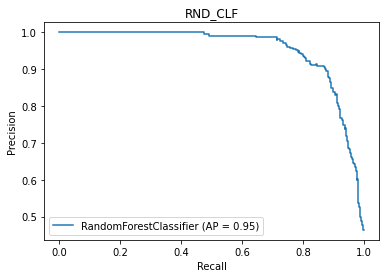

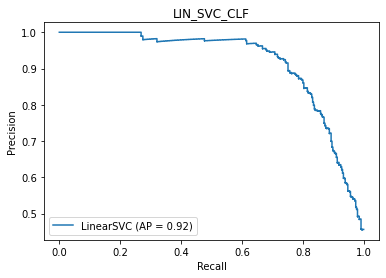

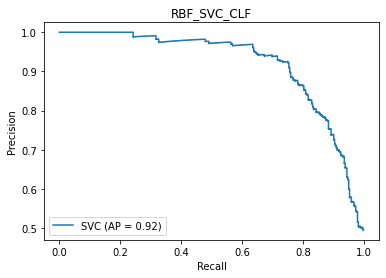

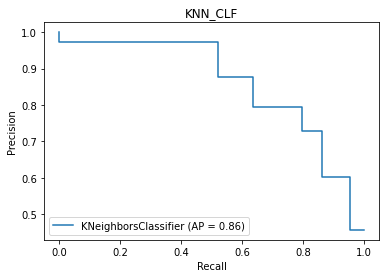

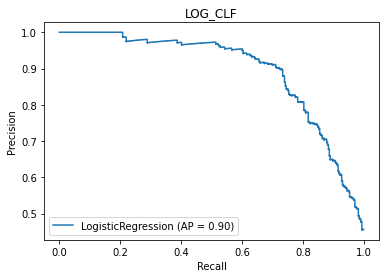

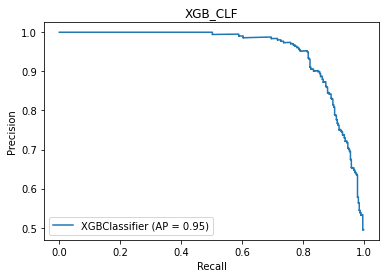

In [33]:
from sklearn.metrics import plot_precision_recall_curve

for name, model in models.items():
    disp = plot_precision_recall_curve(model, x_test, y_test)
    disp.ax_.set_title(name.upper())

In [12]:
rnd_clf = models['rnd_clf']
xgb_clf = models['xgb_clf'] # Two of the better models
lda = lda_info['best_model']

joblib.dump(rnd_clf, 'models/binary_rnd_clf')
joblib.dump(xgb_clf, 'models/binary_xgb_clf')

ann.save('models/multilabel_ann')
lda.save('models/lda')